In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.transforms as mtransforms
from matplotlib.figure import Figure
import warnings
warnings.filterwarnings("ignore")

from numpy.fft import rfft, irfft, rfftfreq
from scipy import signal, fftpack

from statsmodels.tsa.seasonal import seasonal_decompose

data = pd.read_csv("../data/daily_sunspots_time_series_1850-01_2024-05.csv", parse_dates=['date'])
data.set_index('date', inplace = True)
data = data.drop('indicator', axis = 1)

%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [207]:
data.columns

Index(['year', 'month', 'day', 'date_frac', 'counts', 'std', 'nobs'], dtype='object')

In [196]:
def annot_max(x,y,ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text = f"x = {xmax:.3f}, y = {ymax:.3f}, (period: {(1./xmax):.2f} days)"
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle = "square, pad =0.3", fc = "w", ec = "k", lw = 0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)

In [197]:
n_obs = len(data.counts)
sunspot_ft = np.abs(rfft(data.counts))
sunspot_freq = rfftfreq(n_obs)
sunspot_ft

array([5.31097600e+06, 6.61147375e+05, 5.12496025e+05, ...,
       2.70621870e+03, 1.69472842e+03, 4.56426509e+03])

In [198]:
sunspot_freq

array([0.00000000e+00, 1.57052440e-05, 3.14104880e-05, ...,
       4.99960737e-01, 4.99976442e-01, 4.99992147e-01])

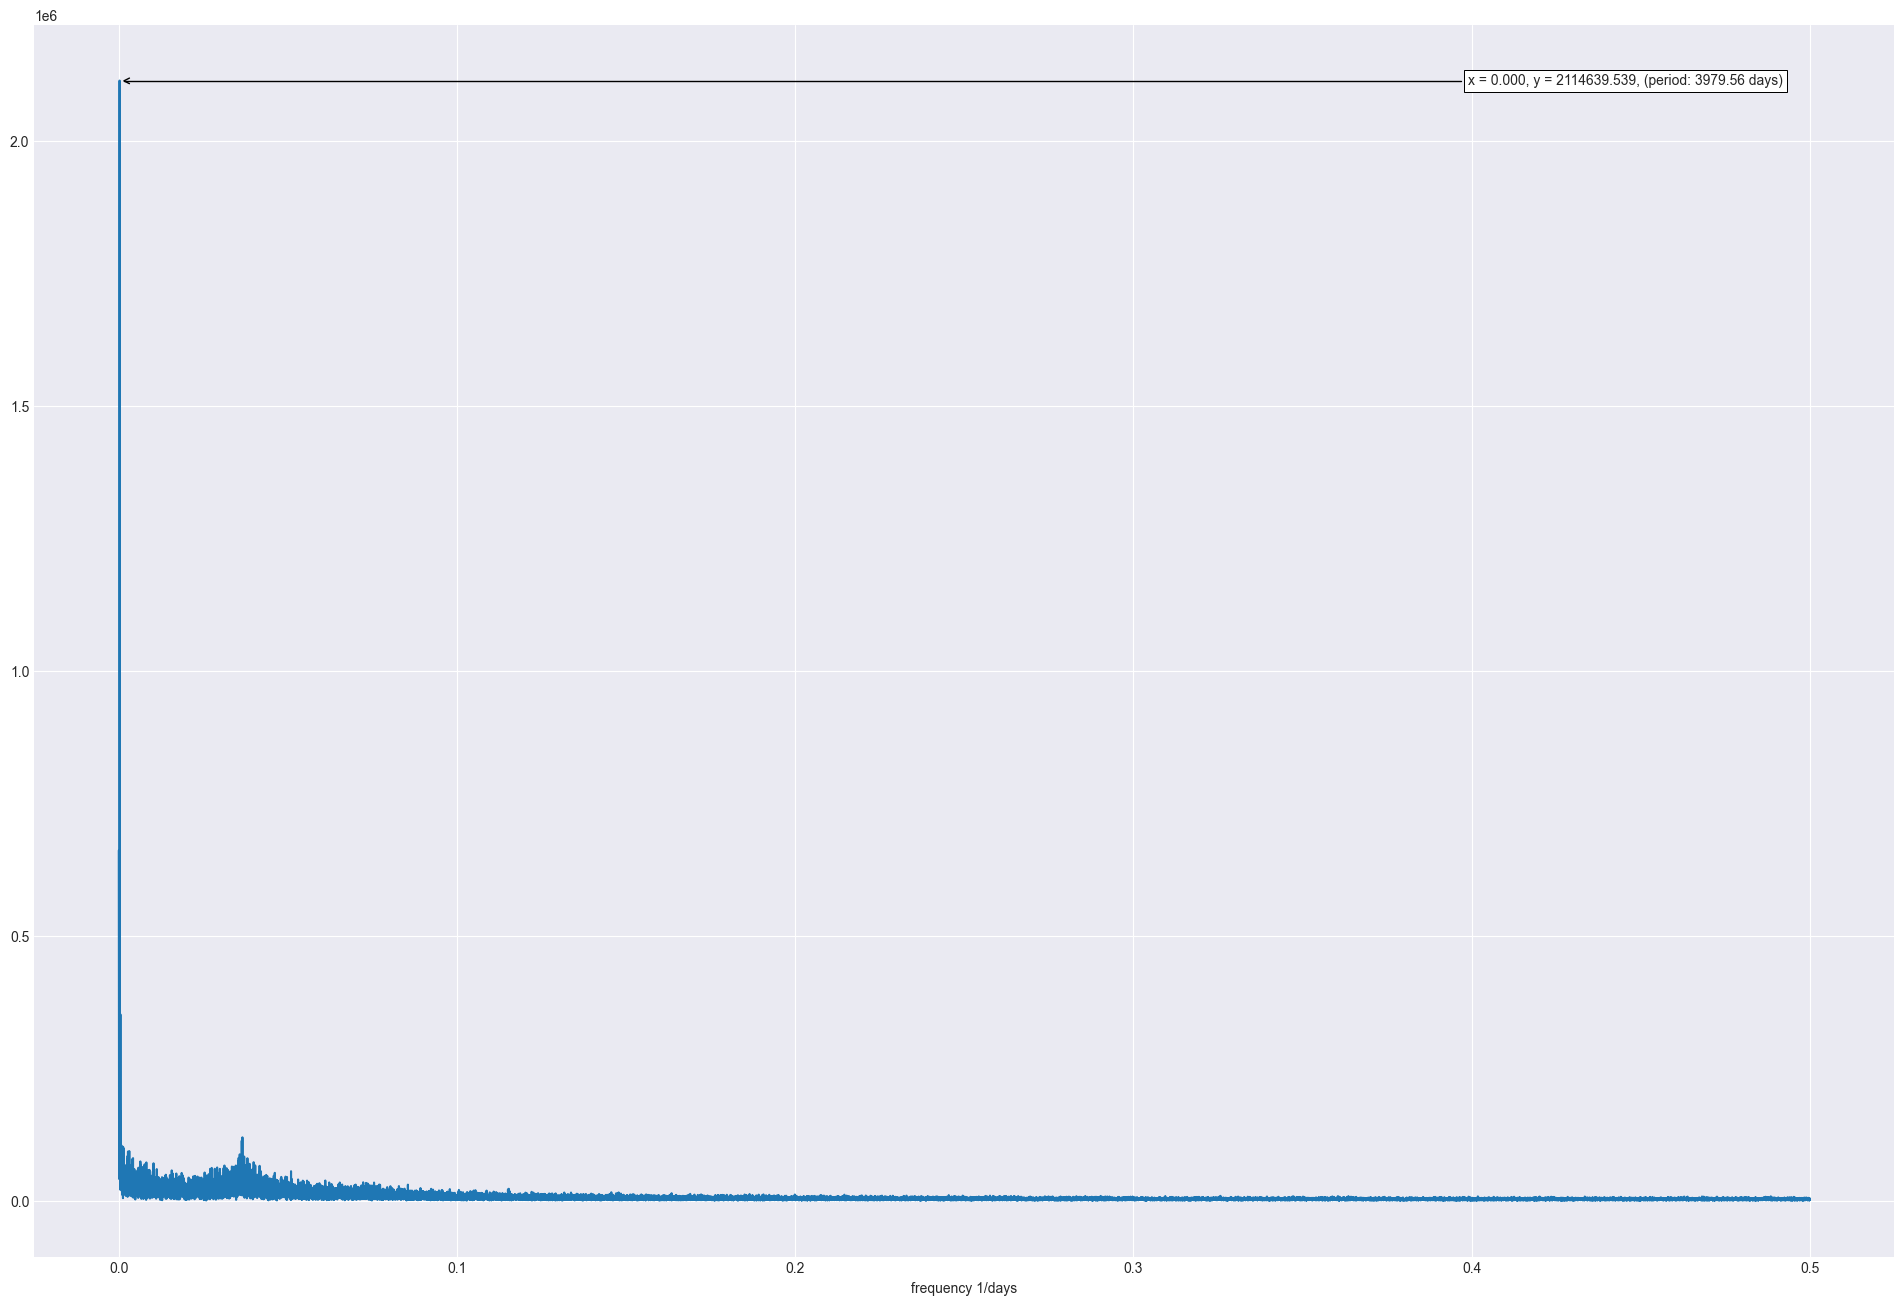

In [199]:
plt.figure(figsize=(24,16))
plt.plot(sunspot_freq[1:], sunspot_ft[1:])
annot_max(sunspot_freq[1:], sunspot_ft[1:])

plt.xlabel('frequency 1/days')
plt.show()

In [200]:
sp = pd.DataFrame({'freqency [1/day]':sunspot_freq[1: ], 'y':sunspot_ft[1: ]})
sp['period [days]'] = (1/sp['freqency [1/day]'])

sp_sort = sp.sort_values(by=['y'], ascending=False).head().to_csv('seasonality.csv', index=False)

In [201]:
T = int(1/sunspot_freq[1:][np.argmax(sunspot_ft[1:])])

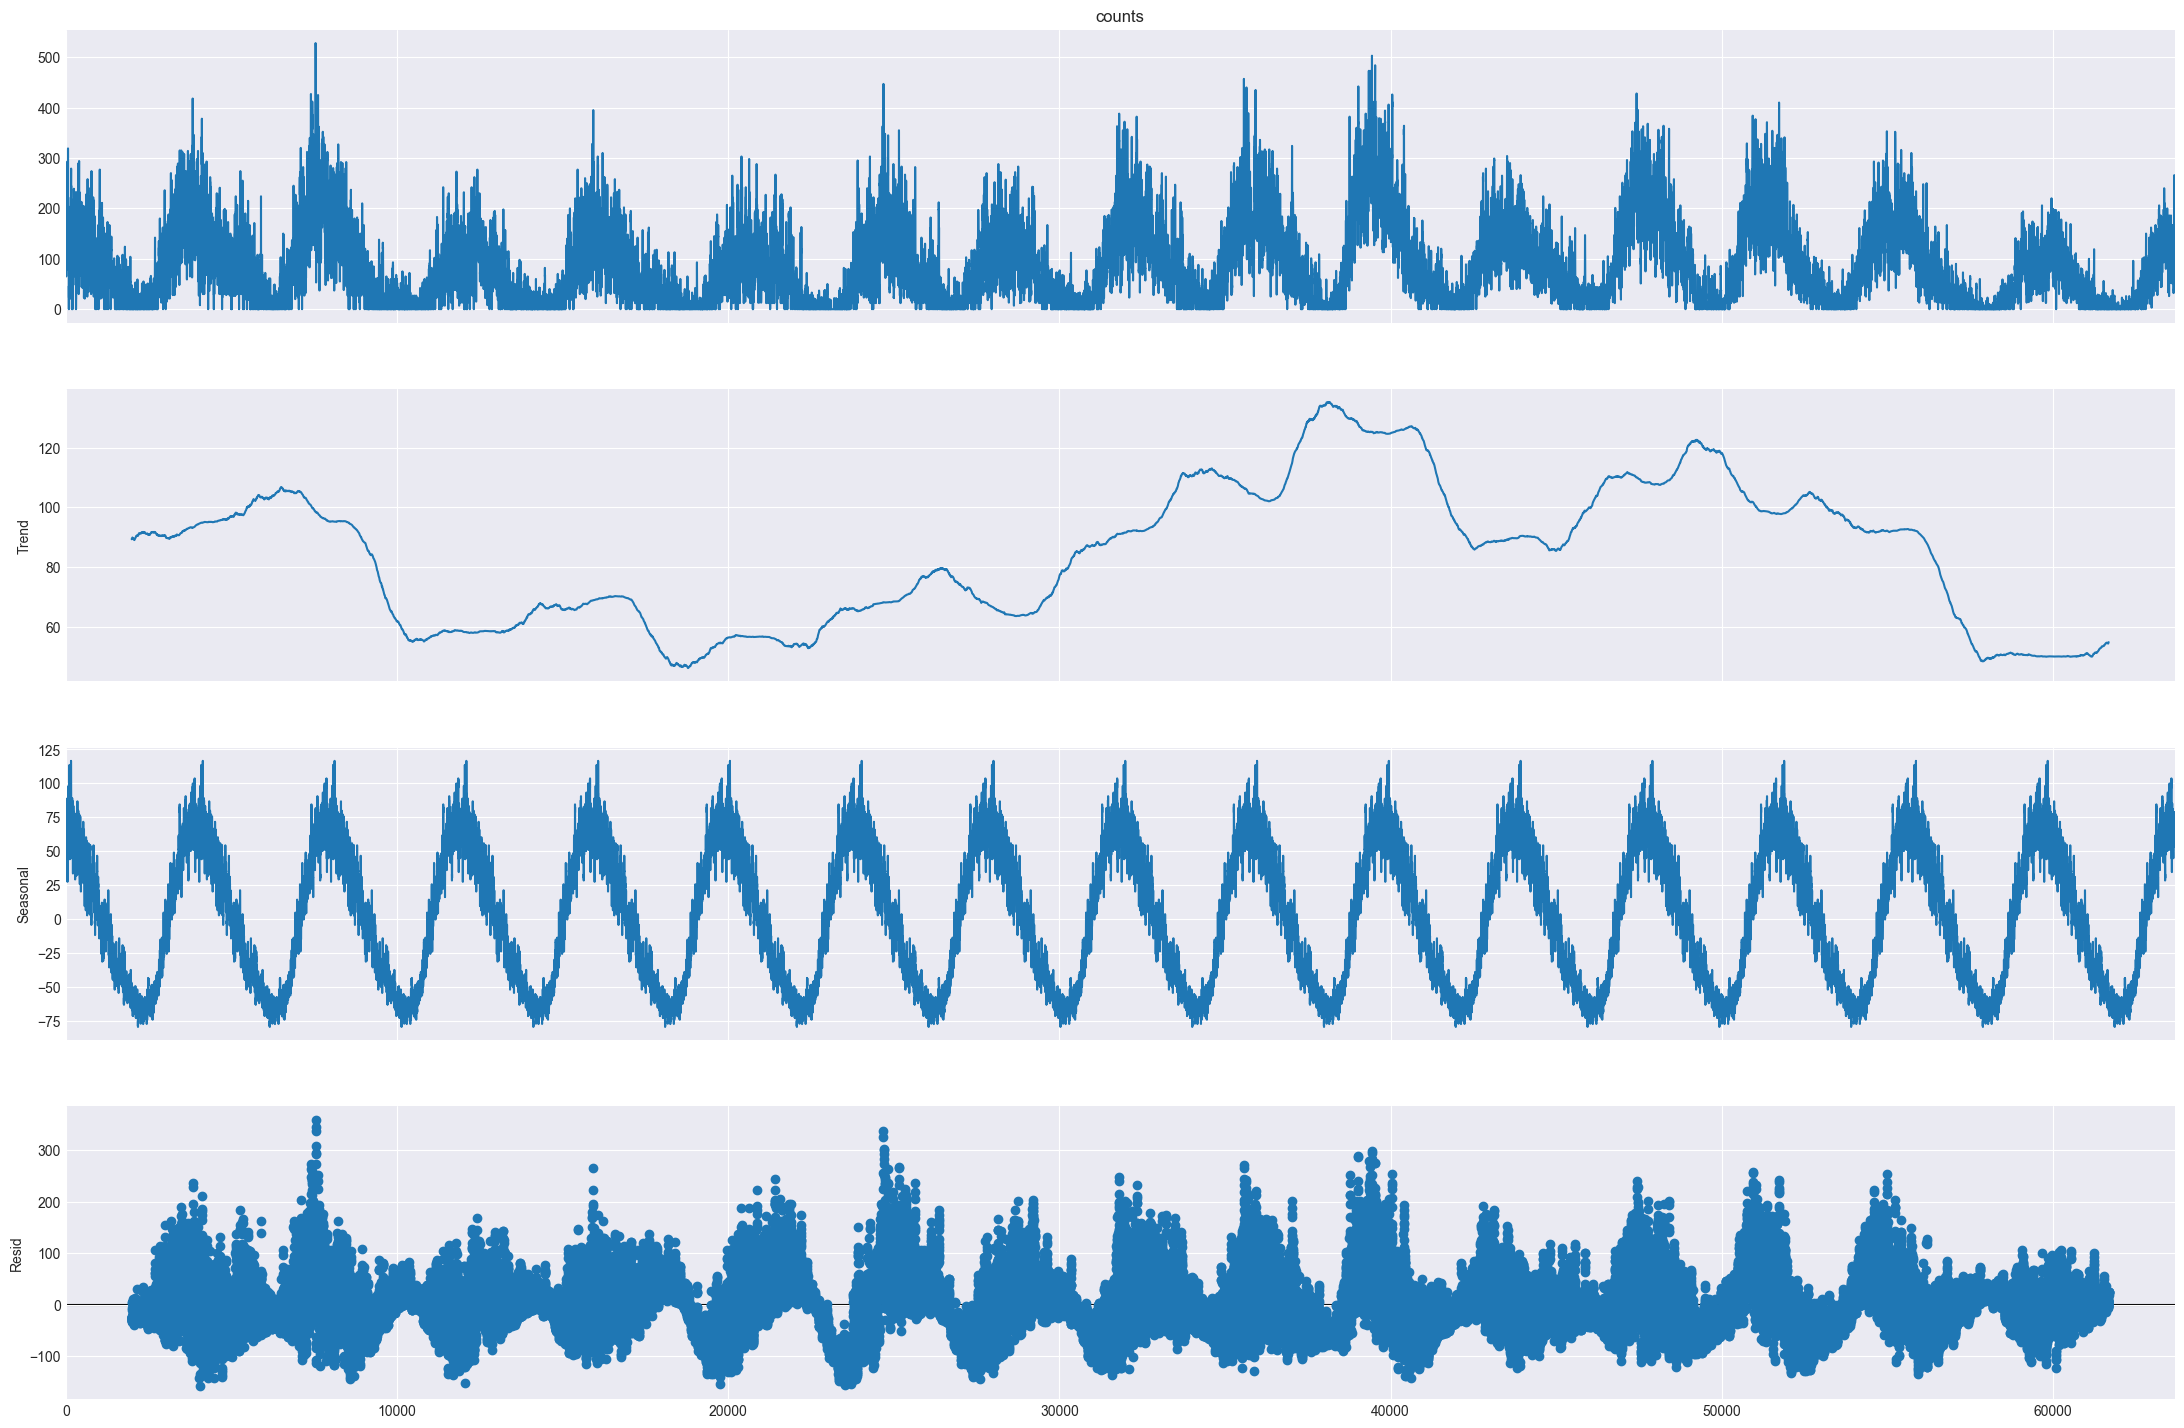

In [202]:
decomposition = seasonal_decompose(data.counts, model = 'add', period = T)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig = decomposition.plot()
fig.set_size_inches((24, 16))
plt.show()

## Smoothing the signal

In [214]:
def low_pass(s, threshold=2e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    display(1/frequencies)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

data['counts_smoothed'] = low_pass(data['counts'])

fig = plt.figure(figsize=(24,16))
plt.plot(data['counts'], linewidth=1, color = 'lightgrey')
plt.plot(data['counts_smoothed'], linewidth=4, color = 'black')

plt.xlabel('date',fontsize=40, labelpad=25)
plt.ylabel('Sunspot Counts',fontsize=40, labelpad=25)
plt.legend(['Real value','FFT smoothing'], prop={'size': 20})
plt.title('',fontsize=40, pad=30)                  
plt.show()
                                                 

array([           inf, 2.00000000e-03, 1.00000000e-03, ...,
       6.28259094e-08, 6.28239359e-08, 6.28219626e-08])

ValueError: Length of values (63672) does not match length of index (63673)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105bba350>>
Traceback (most recent call last):
  File "/Users/manuellautaro/Documents/Spiced Academy/Final_Project/ConvolutionalTimeTravellers/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line -1, in _clean_thread_parent_frames
KeyboardInterrupt: 


KeyboardInterrupt: 

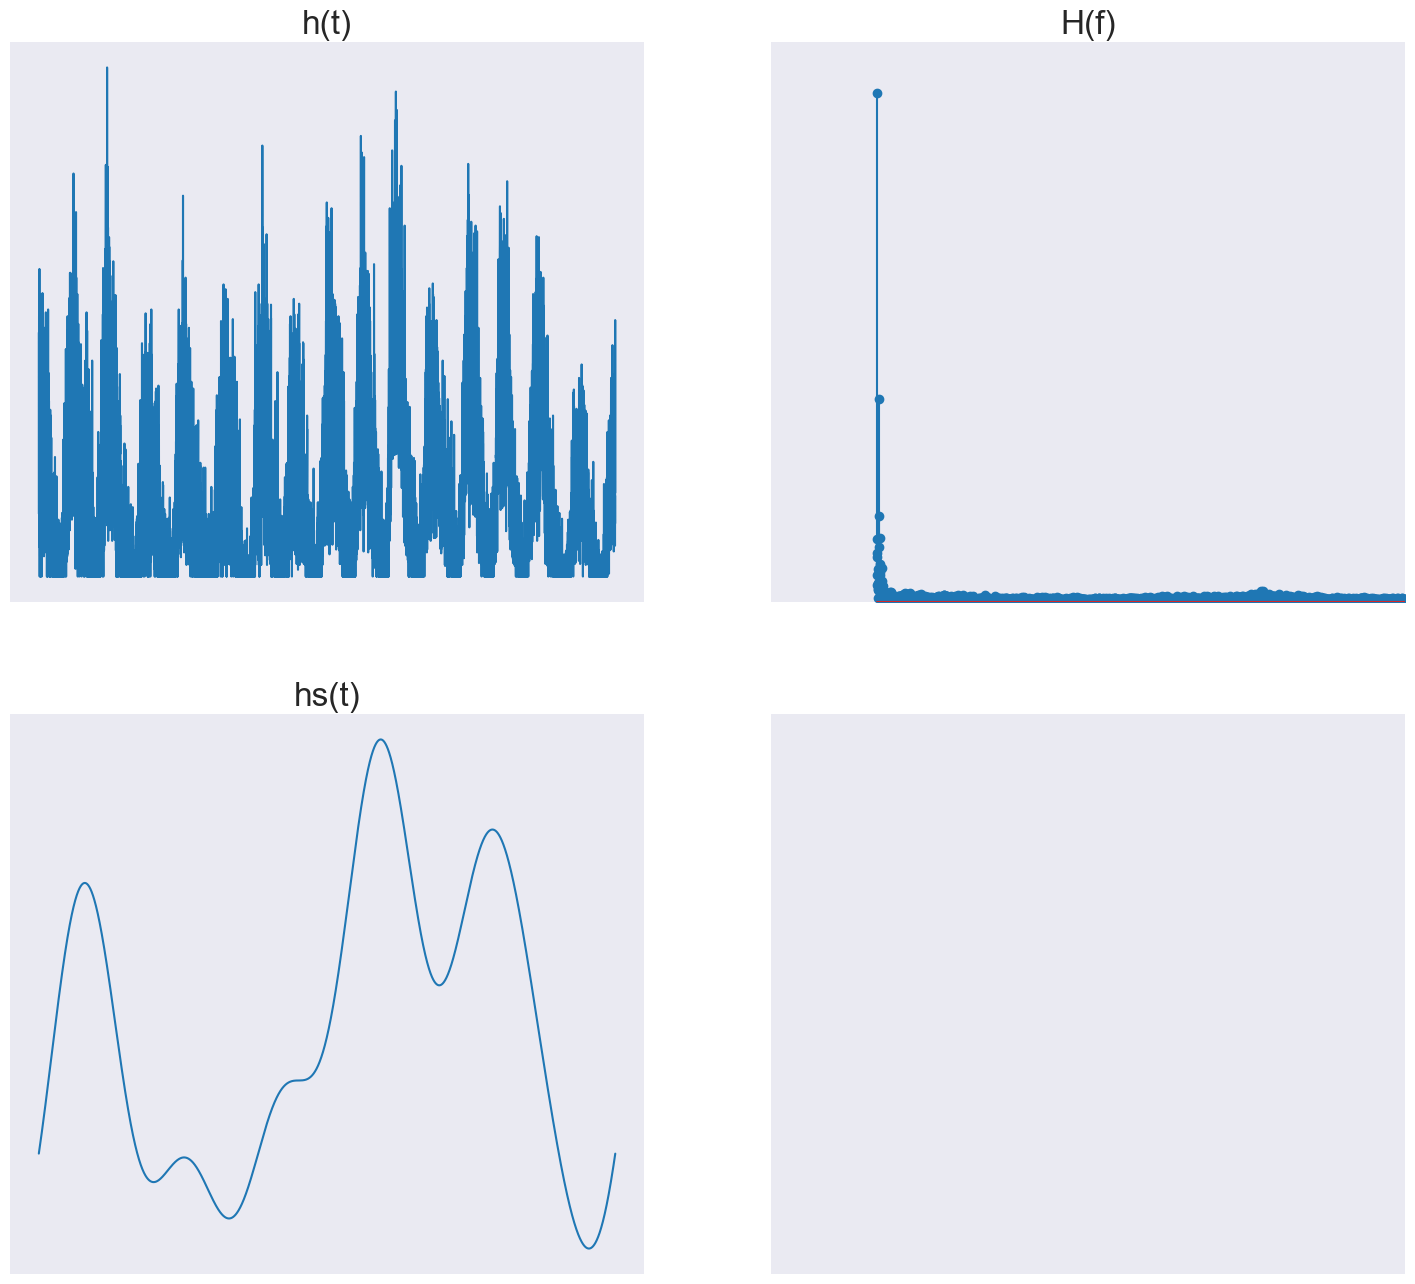

In [219]:
def plot_frame(threshold=1000):
  f1 = data['counts']
  functions = [f1]
  fft_functions = []
  freq_functions = []

  for i in range(len(functions)):
    fft_functions.append(rfft(functions[i]))
    freq_functions.append(rfftfreq(len(functions[i])))

  fig = plt.figure(figsize=(18, 16))
  columns = 2
  rows = 2

  fourier = fft_functions[0].copy()
  frequencies = rfftfreq(f1.size, d=2e-3 / f1.size)
  freq_functions.append(frequencies)
  fourier[frequencies > threshold] = 0
  fft_functions.append(
      fourier
  )
  functions.append(
    irfft(fft_functions[-1])
  )

  ax = []

  for i in range(columns*rows):
      ax.append( fig.add_subplot(rows, columns, i+1) )
      ax[-1].get_xaxis().set_visible(False)
      ax[-1].get_yaxis().set_visible(False)

      if(i == 0):
        ax[-1].set_title("h(t)", fontsize=24)
        plt.plot(functions[0])

      if(i == 1):
        plt.stem(np.abs(freq_functions[0]), np.abs(fft_functions[0]))
        ax[-1].set_xlabel("frequency")
        ax[-1].set_title("H(f)", fontsize=24)
        ax[-1].set_xlim(min(np.abs(freq_functions[0]))-0.01, max(np.abs(freq_functions[0]))/10.0)
        ax[-1].set_ylim(min(np.abs(fft_functions[0])), max(np.abs(fft_functions[0]))*1.1)
      
      if(i == 2):
        ax[-1].set_title("hs(t)", fontsize=24)
        plt.plot(functions[1])

      if(i == 3):
        plt.stem(np.abs(freq_functions[0]), np.abs(fft_functions[1]))
        ax[-1].set_title("Hs(f)", fontsize=24)
        ax[-1].set_xlabel("frequency")
        ax[-1].set_xlim(min(np.abs(freq_functions[0]))-0.01, max(np.abs(freq_functions[0]))/10.0)
        ax[-1].set_ylim(min(np.abs(fft_functions[0])), max(np.abs(fft_functions[0]))*1.1)
        trans = mtransforms.blended_transform_factory(ax[-1].transData, ax[-1].transAxes)
        #ax[-1].axhline(theta, color='green', lw=2, alpha=0.5)
        #ax[-1].axhline(-theta, color='red', lw=2, alpha=0.5)
        # ax[-1].fill_between(np.abs(freq_functions[0]), 0, 1, where=np.abs(fft_functions[1]) > 0, facecolor='green', alpha=0.5, transform=trans)
        ax[-1].fill_between(np.abs(freq_functions[0]), 0, 1, where=np.abs(fft_functions[1]) == 0, facecolor='red', alpha=0.5, transform=trans)

  ax0tr = ax[0].transData
  ax1tr = ax[1].transData
  figtr = fig.transFigure.inverted()
  ptB = figtr.transform(ax0tr.transform((1, 1)))
  ptE = figtr.transform(ax1tr.transform((-0.025, 275)))
  
  #plt.savefig(f'{threshold}.png')
  plt.close()

steps = list(range(0, 25500, 30))
steps[0] += 1
for step in steps:
  plot_frame(step)
steps.append(10000000000) #dirty way to disable filter
plot_frame(10000000000)